In [19]:
#Oppgave 2
import requests
import pandas as pd
import json
import random
import numpy as np
from pandasql import sqldf

# Henter inn dataen
API_URL = "https://api.met.no/weatherapi/locationforecast/2.0/compact"
headers = {"User-Agent": "MyWeatherApp/1.0 (contact@example.com)", "Accept": "application/json"}
params = {"lat": 59.91, "lon": 10.75}  # Oslo koordinater

response = requests.get(API_URL, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()
    with open("../data/json/weather_data.json", "w") as f:
        json.dump(data, f, indent=4)
    print("Data hentet og lagret som JSON")
else:
    print("Feil ved henting av data! Statuskode:", response.status_code)
    exit()

#Behandler data med Pandas
timeseries = data["properties"]["timeseries"]
rows = []

for entry in timeseries:
    time = entry["time"]
    details = entry["data"]["instant"]["details"]
    rows.append({"Tidspunkt": time, **details})

data_frame = pd.DataFrame(rows)


#Oversetter til norsk
column_mapping = {
    "air_pressure_at_sea_level": "Lufttrykk ved havnivå",
    "air_temperature": "Lufttemperatur",
    "wind_speed": "Vindhastighet",
    "wind_from_direction": "Vindretning",
    "relative_humidity": "Relativ fuktighet",
    "cloud_area_fraction": "Skydekke"
}
data_frame.rename(columns=column_mapping, inplace=True)

data_frame.to_csv("../data/csv/weather_data.csv", index=False)
print("Data lagret som CSV")

#Vurdering av kilde
source_info = {
    "Kilde": "MET Norway",
    "Pålitelighet": "Høy",
    "Tilgjengelighet": "Åpen tilgang, krever User-Agent header",
    "Format": "JSON",
    "Oppdateringsfrekvens": "Løpende oppdateringer",
}
print("Vurdering av kilde:")
for key, value in source_info.items():
    print(f"{key}: {value}")

# setter noen tilfeldige verdier til NaN
for col in ["Lufttempereatur", "Vindhastighet"]:
    idx = random.sample(range(len(data_frame)), k=5)
    data_frame.loc[idx, col] = np.nan

# setter noen temperaturer til uealistiske
data_frame.loc[random.randint(0, len(data_frame)), "Lufttemperatur"] = -999 # svært lav
data_frame.loc[random.randint(0, len(data_frame)), "Lufttemperatur"] = 999  # svært høy

data_frame.loc[random.randint(0, len(data_frame)), "Lufttemperatur"] = "Feil" # string istedenfor tall 


#Data analyse med PandaSQL
pysqldf = lambda q: sqldf(q, globals())
query = """
SELECT Tidspunkt, Lufttemperatur, Vindhastighet
FROM data_frame
WHERE Lufttemperatur IS NOT NULL
ORDER BY Tidspunkt ASC
LIMIT 15;
"""
result = pysqldf(query)
print("\nEksempel på analyserte data:")
print(result)




Data hentet og lagret som JSON
Data lagret som CSV
Vurdering av kilde:
Kilde: MET Norway
Pålitelighet: Høy
Tilgjengelighet: Åpen tilgang, krever User-Agent header
Format: JSON
Oppdateringsfrekvens: Løpende oppdateringer

Eksempel på analyserte data:
               Tidspunkt Lufttemperatur  Vindhastighet
0                   None           Feil            NaN
1   2025-05-25T15:00:00Z           11.4            2.9
2   2025-05-25T16:00:00Z           11.4            3.1
3   2025-05-25T17:00:00Z           11.5            2.1
4   2025-05-25T18:00:00Z           11.5            1.8
5   2025-05-25T19:00:00Z           11.7            2.5
6   2025-05-25T20:00:00Z           11.9            4.9
7   2025-05-25T21:00:00Z           12.1            5.5
8   2025-05-25T22:00:00Z           12.4            5.5
9   2025-05-25T23:00:00Z         -999.0            4.2
10  2025-05-26T00:00:00Z           12.6            4.0
11  2025-05-26T01:00:00Z           12.5            4.9
12  2025-05-26T02:00:00Z           

C:\Users\krist\AppData\Local\Temp\ipykernel_18692\489656083.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Feil' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_frame.loc[random.randint(0, len(data_frame)), "Lufttemperatur"] = "Feil" # string istedenfor tall


In [20]:
#Oppgave 3

#Håndtering av manglende verdier 
def clean_data(data_frame):
    """Formelen clean_data tar inn data framen generert i oppgave 2, og fjerner rader og kolonner med manglende verdier (NaN)"""
    pass
    data_frame.dropna(subset=["Lufttemperatur", "Vindhastighet"])  
    return data_frame
print(clean_data.__doc__)

# koverterer kolonner til riktige datatyper (fjerner tekstfil)
data_frame["Lufttemperatur"] = pd.to_numeric(data_frame["Lufttemperatur"], errors="coerce")
data_frame["Vindhastighet"] = pd.to_numeric(data_frame["Vindhastighet"], errors="coerce")

# fjerner urealistiske verdier 
data_frame = data_frame[(data_frame["Lufttemperatur"] > -60) & (data_frame["Lufttemperatur"] < 60)]
data_frame = data_frame[(data_frame["Vindhastighet"] >= 0) & (data_frame["Vindhastighet"] < 70)]

data_frame_cleaned = clean_data(data_frame)
print("\nData etter håndtering av manglende verdier:")
print(data_frame_cleaned.head())

#List comprenhensions 
data_frame_cleaned["Tidspunkt"] = [t.replace("T", " ") for t in data_frame_cleaned["Tidspunkt"]]
print("\nTidspunkt formatert:")
print(data_frame_cleaned["Tidspunkt"].head())

#Manipulerer data med Pandas SQL 
query = """
SELECT Tidspunkt, Lufttemperatur, Vindhastighet
FROM data_frame_cleaned
WHERE Lufttemperatur > 0
ORDER BY Vindhastighet DESC
LIMIT 5;
"""
result = pysqldf(query)
print("\nEksempel på filtrerte data:")
print(result)

#Forventede uregelmessigheter og håndtering
print("\nForventede uregelmessigheter og håndtering:")
print("- Manglende verdier: Løst med dropna().")
print("- Uregelmessige tidspunkter: Formatert med list comprehension.")
print("- Ekstreme verdier: Kan analyseres med ytterligere filtrering.")


Formelen clean_data tar inn data framen generert i oppgave 2, og fjerner rader og kolonner med manglende verdier (NaN)

Data etter håndtering av manglende verdier:
              Tidspunkt  Lufttrykk ved havnivå  Lufttemperatur  Skydekke  \
0  2025-05-25T15:00:00Z                 1000.6            11.4     100.0   
1  2025-05-25T16:00:00Z                 1000.1            11.4     100.0   
2  2025-05-25T17:00:00Z                  999.5            11.5     100.0   
3  2025-05-25T18:00:00Z                  999.1            11.5     100.0   
4  2025-05-25T19:00:00Z                  998.6            11.7     100.0   

   Relativ fuktighet  Vindretning  Vindhastighet  Lufttempereatur  
0               87.1         87.8            2.9              NaN  
1               88.8         80.7            3.1              NaN  
2               90.1         86.6            2.1              NaN  
3               91.8        128.1            1.8              NaN  
4               91.7        139.2      

Statistiske mål:
 - korrelasjon mellom lufttemperatur og vindhastighet: 0.11
 - Antall observasjoner uten skjevheter (temperatur): 76 av 76


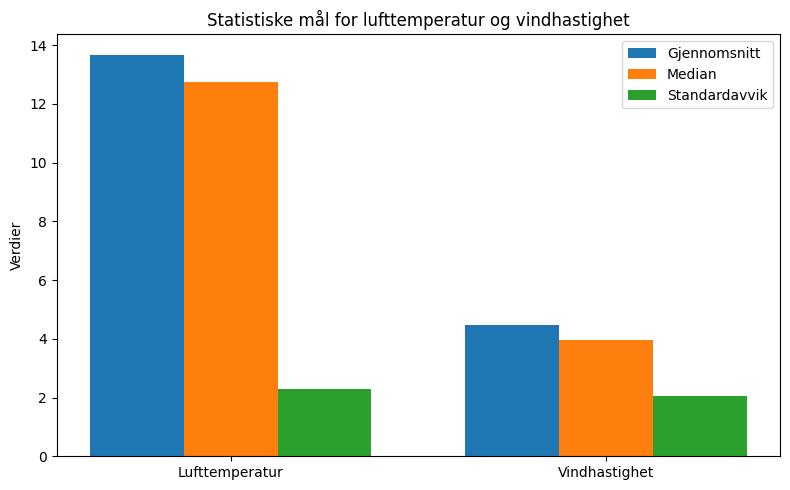

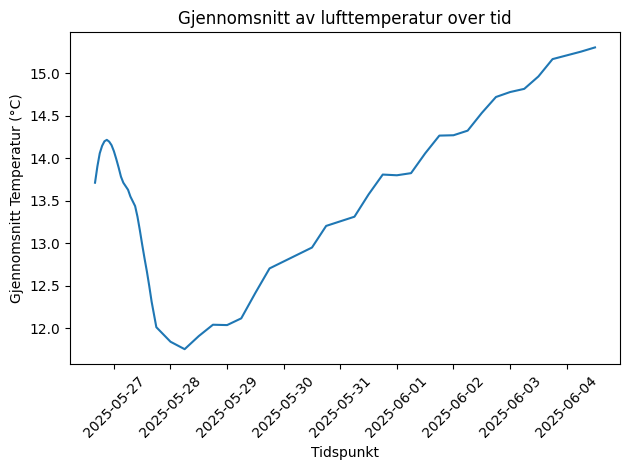

In [21]:
#Oppgave 4
import matplotlib.pyplot as plt


#Konverterer kolonner til NumPy-arrays
temp_arr = data_frame_cleaned['Lufttemperatur'].to_numpy()
wind_arr = data_frame_cleaned['Vindhastighet'].to_numpy()

stats = {
    'Lufttemperatur': {
        'gjennomsnitt': np.mean(temp_arr),
        'median': np.median(temp_arr),
        'standardavvik': np.std(temp_arr, ddof=1)
    },
    'Vindhastighet': {
        'gjennomsnitt': np.mean(wind_arr),
        'median': np.median(wind_arr),
        'standardavvik': np.std(wind_arr, ddof=1)
    }
}
print("Statistiske mål:")

#correlationsanalyse mellom lufttemperatur og vindhastighet
correlation = data_frame_cleaned['Lufttemperatur'].corr(data_frame_cleaned['Vindhastighet'])
print(f" - korrelasjon mellom lufttemperatur og vindhastighet: {correlation:.2f}")

#Håndtere skjevheter basert på IQR (Interquatile Range)
Q1 = data_frame_cleaned['Lufttemperatur'].quantile(0.25)
Q3 = data_frame_cleaned['Lufttemperatur'].quantile(0.75)
IQR = Q3 - Q1
mask_iqr = (
    (data_frame_cleaned['Lufttemperatur'] >= Q1 - 1.5 * IQR) &
    (data_frame_cleaned['Lufttemperatur'] <= Q3 + 1.5 * IQR)
)
data_frame_no_outliers = data_frame_cleaned[mask_iqr]
print(f" - Antall observasjoner uten skjevheter (temperatur): {len(data_frame_no_outliers)} av {len(data_frame_cleaned)}")


# Forbereder data for plotting med matplotlib
types = list(stats.keys())
means = [stats[t]['gjennomsnitt'] for t in types]
medians = [stats[t]['median'] for t in types]
standard_deviation = [stats[t]['standardavvik'] for t in types]

x = range(len(types))
width = 0.25

plt.figure(figsize=(8, 5))

plt.bar([p - width for p in x], means, width=width, label='Gjennomsnitt')
plt.bar(x, medians, width=width, label='Median')
plt.bar([p + width for p in x], standard_deviation, width=width, label='Standardavvik')

plt.xticks(x, types)
plt.ylabel('Verdier')
plt.title('Statistiske mål for lufttemperatur og vindhastighet')
plt.legend()
plt.tight_layout()
plt.show()


#Finne og visualiser mønstre i data
window = 24
temp_arr = data_frame_cleaned['Lufttemperatur'].to_numpy()

weights = np.ones(window) / window  
moving_avg = np.convolve(temp_arr, weights, mode='valid')


times = pd.to_datetime(data_frame_cleaned['Tidspunkt']).to_numpy()
times_ma = times[window-1:]


plt.figure()
plt.plot(times_ma, moving_avg)
plt.xlabel('Tidspunkt')
plt.ylabel('Gjennomsnitt Temperatur (°C)')
plt.title('Gjennomsnitt av lufttemperatur over tid')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





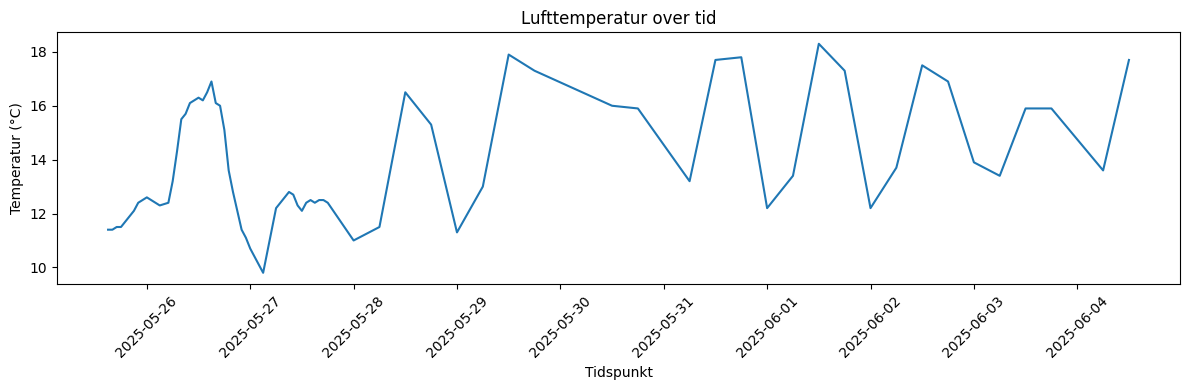

Luftemperatur over tid:


,Dato,Klokkeslett,Lufttemperatur
3,2025-05-25,18:00,11.500000
9,2025-05-26,00:00,12.600000
15,2025-05-26,06:00,13.200000
21,2025-05-26,12:00,16.300000
27,2025-05-26,18:00,15.100000
33,2025-05-27,00:00,10.700000
39,2025-05-27,06:00,12.200000
45,2025-05-27,12:00,12.100000
51,2025-05-27,18:00,12.400000
52,2025-05-28,00:00,11.000000


Høyeste temperatur hver dag:


,Dato,Lufttemperatur
0,2025-05-25,12.400000
1,2025-05-26,16.900000
2,2025-05-27,12.800000
3,2025-05-28,16.500000
4,2025-05-29,17.900000
5,2025-05-30,16.000000
6,2025-05-31,17.800000
7,2025-06-01,18.300000
8,2025-06-02,17.500000
9,2025-06-03,15.900000


interactive(children=(IntSlider(value=24, description='Vindu:', max=72, min=2), Output()), _dom_classes=('widg…

<function __main__.plot_moving_average(window=24)>

Plot av forskjellige grafer


In [ ]:
#oppgave 5
import seaborn as sns

#Lufttemperatur over tid
data_frame_no_outliers['Tidspunkt_data_frame'] = pd.to_datetime(data_frame_no_outliers['Tidspunkt'])
plt.figure(figsize=(12, 4))
sns.lineplot(x='Tidspunkt_data_frame', y='Lufttemperatur', data=data_frame_no_outliers)
plt.xlabel('Tidspunkt')
plt.ylabel('Temperatur (°C)')
plt.title('Lufttemperatur over tid')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Temperatur ved spesifikke tidspunkter

print("Luftemperatur over tid:")
selected_hours = [0, 6, 12, 18]
data_frame_times = data_frame_no_outliers.copy()
data_frame_times['Tidspunkt_data_frame'] = pd.to_datetime(data_frame_times['Tidspunkt'])
data_frame_times['Dato'] = data_frame_times['Tidspunkt_data_frame'].dt.date
data_frame_times['Klokkeslett'] = data_frame_times['Tidspunkt_data_frame'].dt.strftime('%H:%M')
data_frame_table = data_frame_times[data_frame_times['Tidspunkt_data_frame'].dt.hour.isin(selected_hours)][['Dato', 'Klokkeslett', 'Lufttemperatur']]

#Legger til farger
styler = data_frame_table.style.map(
    lambda v: 'background-color: red' if v > 14 else ('background-color: blue' if v < 8 else 'background-color: white'),
    subset=['Lufttemperatur']
)

display(styler)

#Høyeste lufttemperatur
print("Høyeste temperatur hver dag:")

data_frame_temp = data_frame_no_outliers.copy()
data_frame_temp['Dato'] = pd.to_datetime(data_frame_temp['Tidspunkt']).dt.date
daily_max = data_frame_temp.groupby('Dato')['Lufttemperatur'].max().reset_index()

#Legger til farger
styler_max = daily_max.style.map(
    lambda v: 'background-color: red' if v > 14 else ('background-color: blue' if v < 8 else 'background-color: white'),
    subset=['Lufttemperatur']
)

display(styler_max)


from ipywidgets import interact, IntSlider

#Interaktiv visualisering
def plot_moving_average(window=24):
    """Plot av forskjellige grafer""" 
    pass
    arr = data_frame_no_outliers['Lufttemperatur'].to_numpy()
    if window < 1 or window > len(arr):
        return
    weights = np.ones(window) / window
    ma = np.convolve(arr, weights, mode='valid')
    times = pd.to_datetime(data_frame_no_outliers['Tidspunkt']).to_numpy()[window-1:]

    plt.figure(figsize=(10, 4))
    plt.plot(times, ma)
    plt.xlabel('Tidspunkt')
    plt.ylabel(f'Glidende gjennomsnitt ({window}-punkter)')
    plt.title('Interaktiv glidende gjennomsnitt av lufttemperatur')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#Slider
display(interact(plot_moving_average, window=IntSlider(min=2, max=72, step=1, value=24, description='Vindu:')))

print(plot_moving_average.__doc__)  


Mean Squared Error: 2.84
R² Score: 0.29


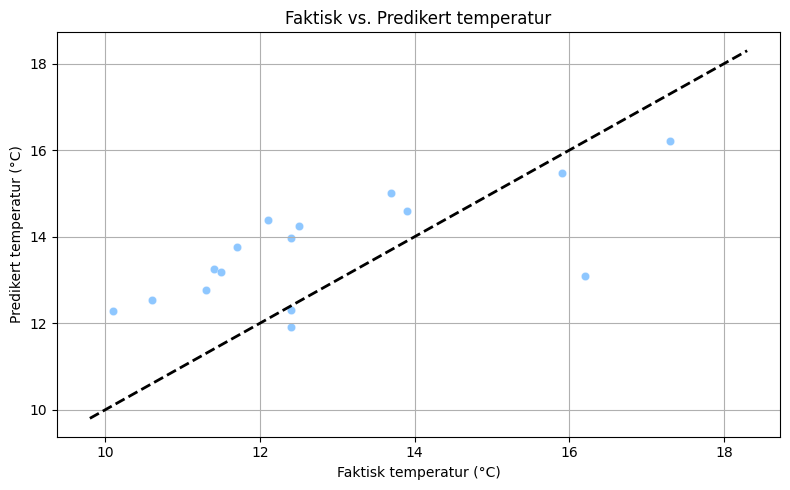

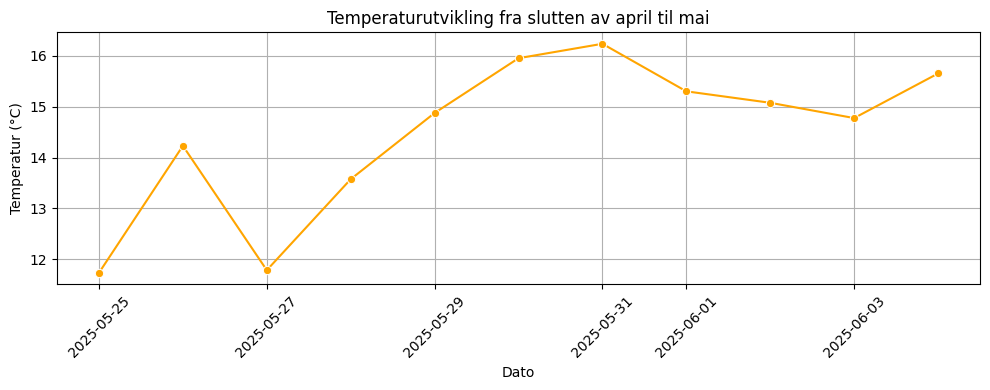

C:\Users\krist\AppData\Local\Temp\ipykernel_18692\3463411542.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Hour", y="Temperature", data=hourly_avg, palette="coolwarm", legend=False)


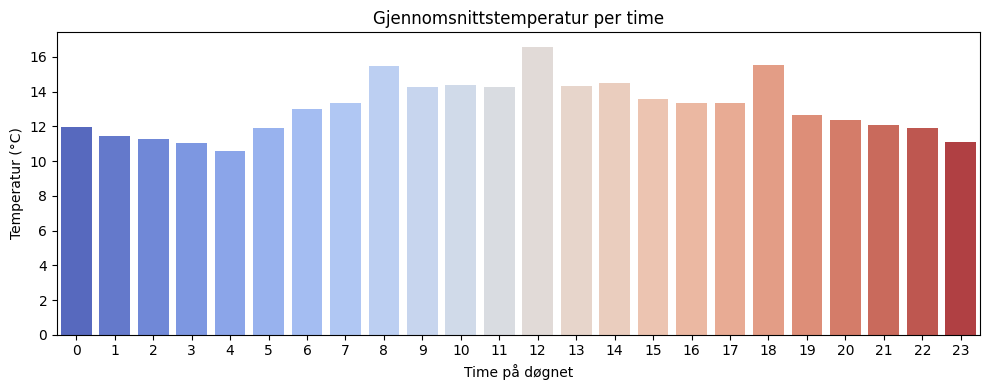

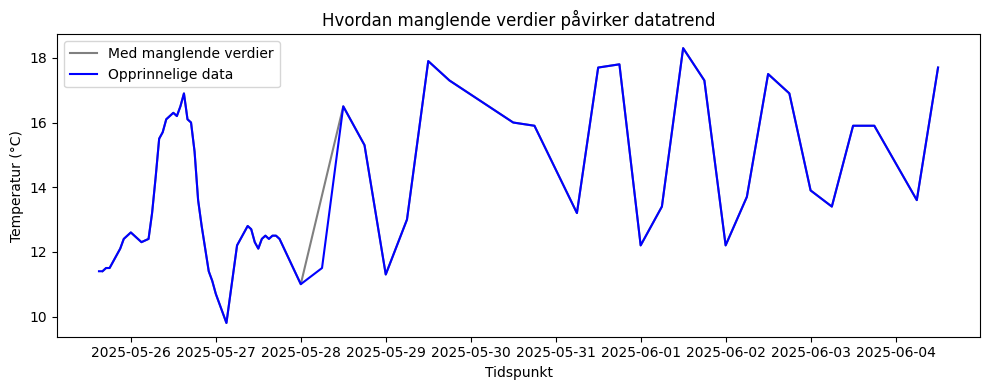

In [23]:
# Oppgave 6: Prediktiv analyse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Forbereder data
data_frame_pred = data_frame_no_outliers.copy()
data_frame_pred['Tidspunkt'] = pd.to_datetime(data_frame_pred['Tidspunkt'])
data_frame_pred['Hour'] = data_frame_pred['Tidspunkt'].dt.hour
data_frame_pred['DayOfYear'] = data_frame_pred['Tidspunkt'].dt.dayofyear
data_frame_pred['Temperature'] = data_frame_pred['Lufttemperatur']

# Fjerner eventuelle manglende verdier
data_frame_pred.dropna(subset=['Temperature'], inplace=True)

x_time = data_frame_pred[['Hour', 'DayOfYear']]
y_temp = data_frame_pred['Temperature']

# Split data
X_train, X_test, y_train, y_test = train_test_split(x_time, y_temp, test_size=0.2, random_state=42)

# Tren modell
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluerer modell
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


# Visualisering

# Faktisk vs predikert temperatur (scatterplot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='dodgerblue')
plt.xlabel("Faktisk temperatur (°C)")
plt.ylabel("Predikert temperatur (°C)")
plt.title("Faktisk vs. Predikert temperatur")
plt.plot([y_temp.min(), y_temp.max()], [y_temp.min(), y_temp.max()], 'k--', lw=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# Gjennomsnittstemperatur per dag i datasettet (Linjediagram)
data_frame_pred['Dato'] = data_frame_pred['Tidspunkt'].dt.date  # Ekstraherer kun dato

daily_avg = data_frame_pred.groupby('Dato')['Temperature'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x='Dato', y='Temperature', data=daily_avg, marker='o', color='orange')
plt.title("Temperaturutvikling fra slutten av april til mai")
plt.xlabel("Dato")
plt.ylabel("Temperatur (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Gjennomsnittstemperatur i et døgn (søylediagram)
hourly_avg = data_frame_pred.groupby("Hour")["Temperature"].mean().reset_index()
plt.figure(figsize=(10, 4))
sns.barplot(x="Hour", y="Temperature", data=hourly_avg, palette="coolwarm", legend=False)
plt.title("Gjennomsnittstemperatur per time")
plt.xlabel("Time på døgnet")
plt.ylabel("Temperatur (°C)")
plt.tight_layout()
plt.show()

# Visulaisere manglende verdier
data_frame_missing = data_frame_no_outliers.copy()
data_frame_missing.loc[::50, 'Lufttemperatur'] = np.nan  

plt.figure(figsize=(10, 4))
sns.lineplot(x=pd.to_datetime(data_frame_missing['Tidspunkt']), y=data_frame_missing['Lufttemperatur'], color='gray', label='Med manglende verdier')
sns.lineplot(x=pd.to_datetime(data_frame_no_outliers['Tidspunkt']), y=data_frame_no_outliers['Lufttemperatur'], color='blue', label='Opprinnelige data')
plt.title("Hvordan manglende verdier påvirker datatrend")
plt.xlabel("Tidspunkt")
plt.ylabel("Temperatur (°C)")
plt.legend()
plt.tight_layout()
plt.show()
